1. The central motivation of the project is to determine whether or not someone will vote based off of participants’ opinions and experiences about voting and use what we discover to address the factors behind why people aren’t voting. 

In [ ]:
import pandas as pd

df = pd.read_csv('nonvoters_data.csv')

In [2]:
df.head()

,RespId,weight,Q1,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,...,Q30,Q31,Q32,Q33,ppage,educ,race,gender,income_cat,voter_category
0,470001,0.7516,1,1,1,2,4,1,4,2,...,2,NaN,1.0,NaN,73,College,White,Female,$75-125k,always
1,470002,1.0267,1,1,2,2,3,1,1,2,...,3,NaN,NaN,1.0,90,College,White,Female,$125k or more,always
2,470003,1.0844,1,1,1,2,2,1,1,2,...,2,NaN,2.0,NaN,53,College,White,Male,$125k or more,sporadic
3,470007,0.6817,1,1,1,1,3,1,1,1,...,2,NaN,1.0,NaN,58,Some college,Black,Female,$40-75k,sporadic
4,480008,0.9910,1,1,1,-1,1,1,1,1,...,1,-1.0,NaN,NaN,81,High school or less,White,Male,$40-75k,always


In [4]:
df['voter_category'].value_counts()

sporadic        2574
always          1811
rarely/never    1451
Name: voter_category, dtype: int64

first, we'll make a histogram plot for each variable--so that we can see the distributions inherint in our raw data--this can be helpful in the future for interpretting results that we get

/var/folders/48/17g34vfn0zx8xptnzvcd0tph0000gn/T/ipykernel_19463/954318556.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


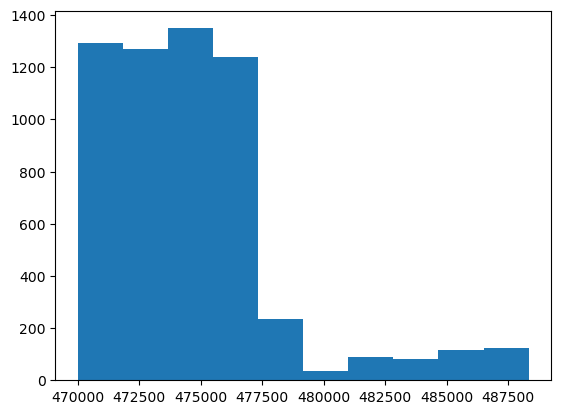

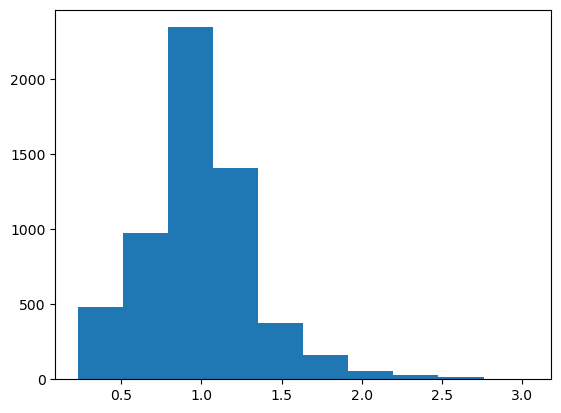

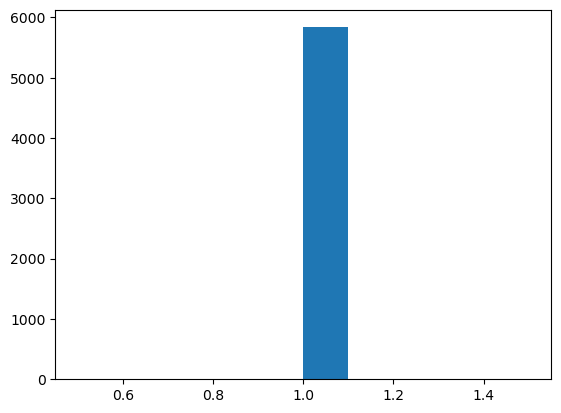

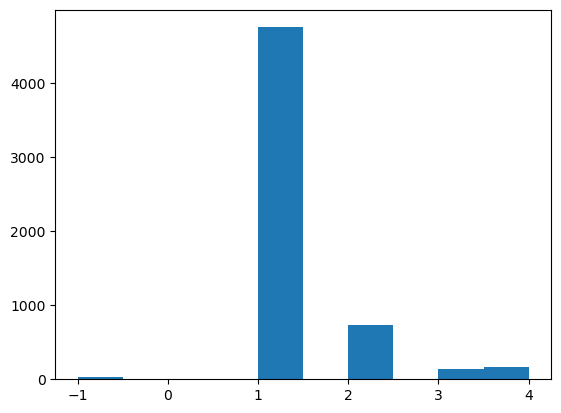

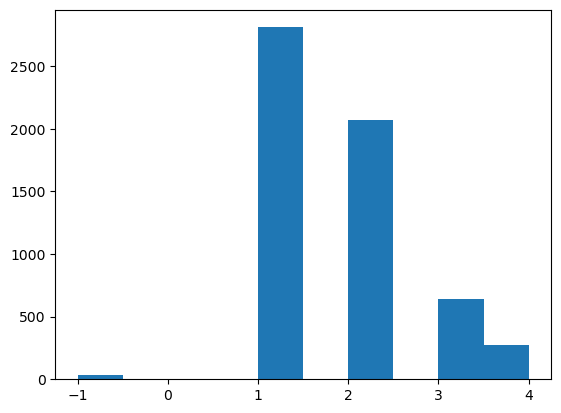

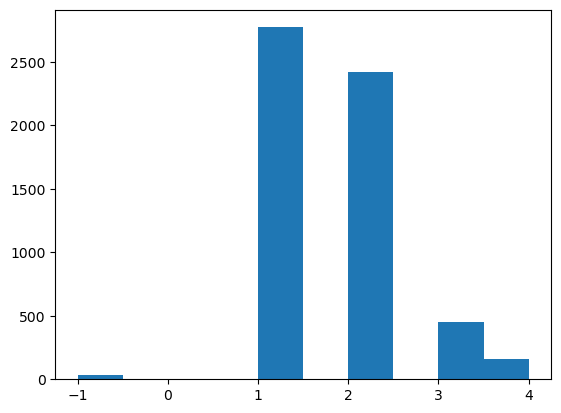

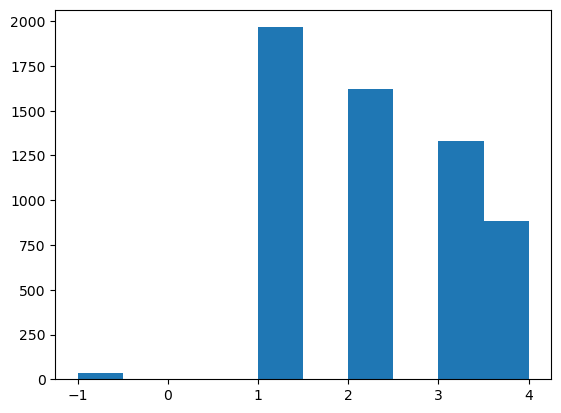

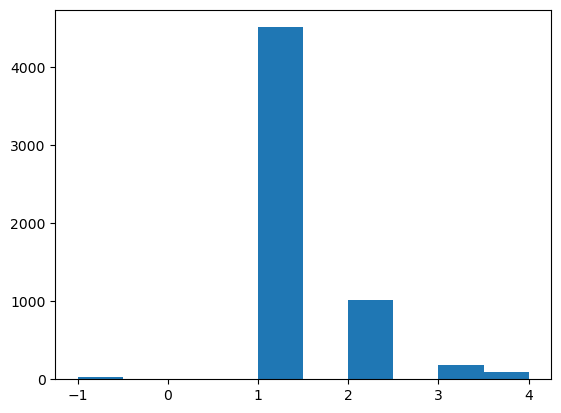

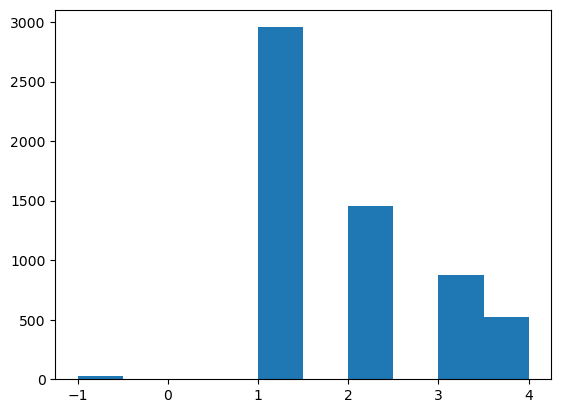

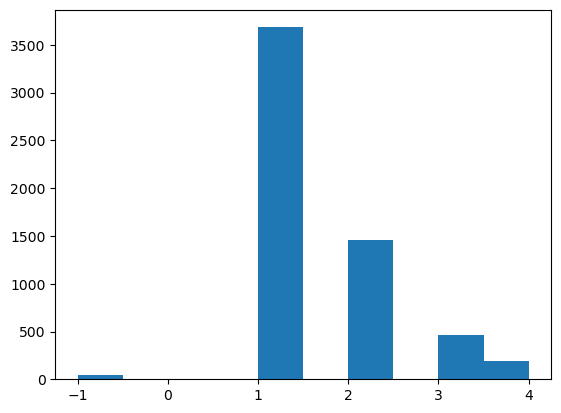

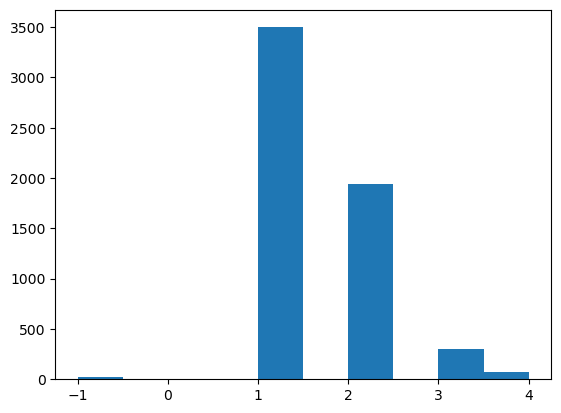

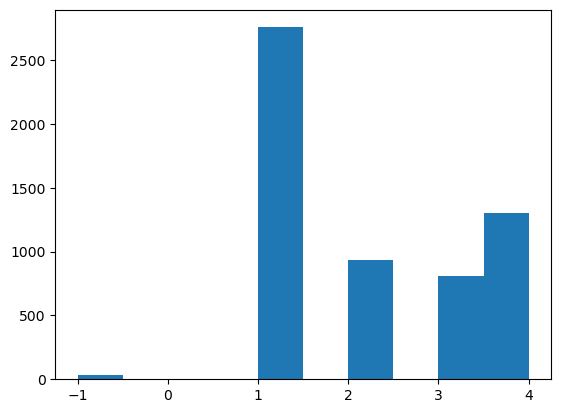

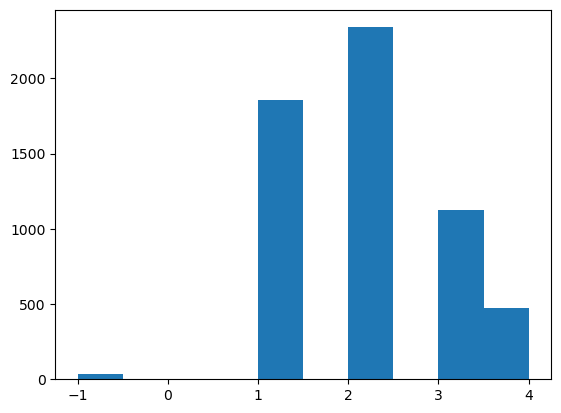

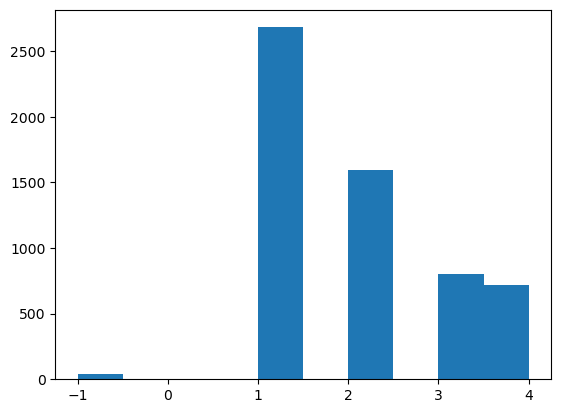

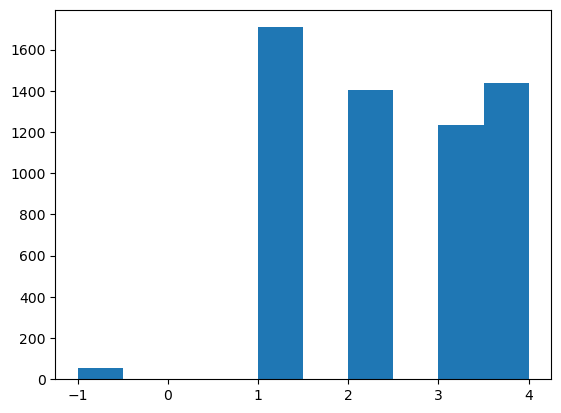

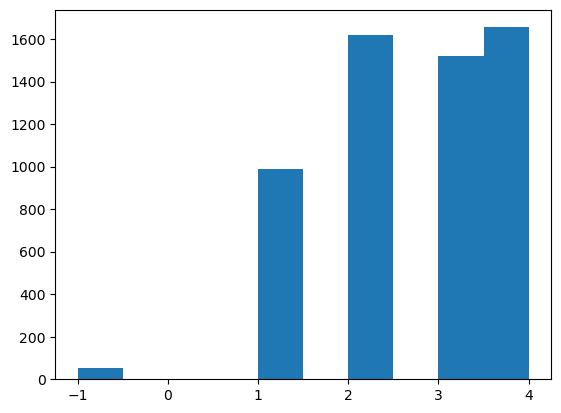

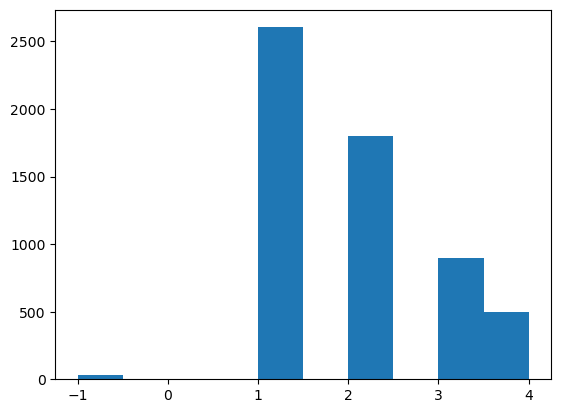

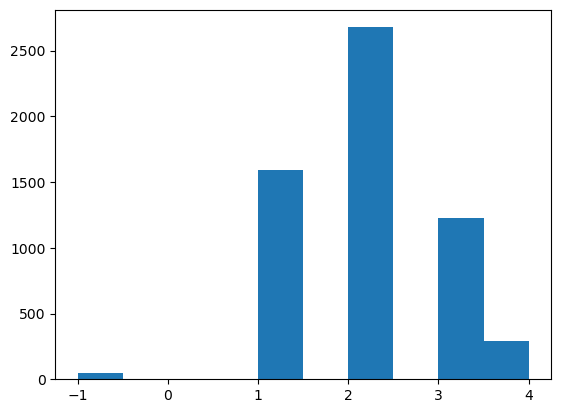

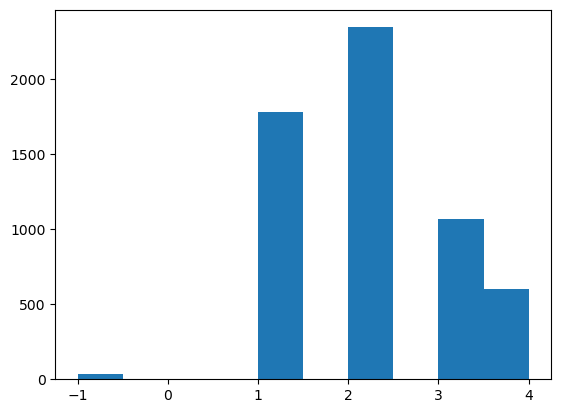

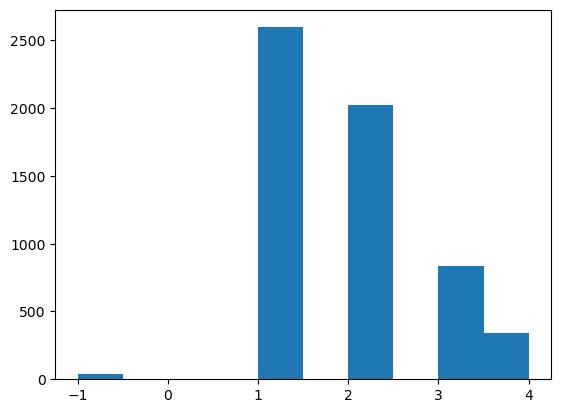

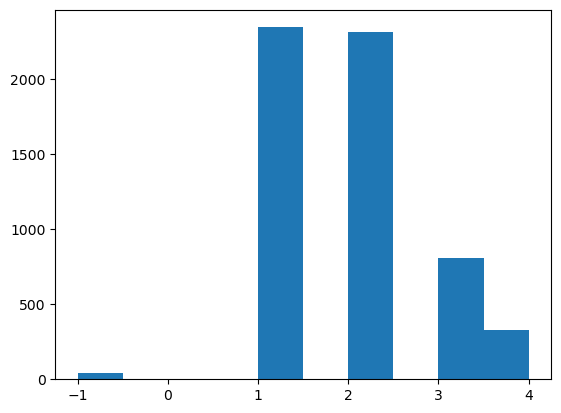

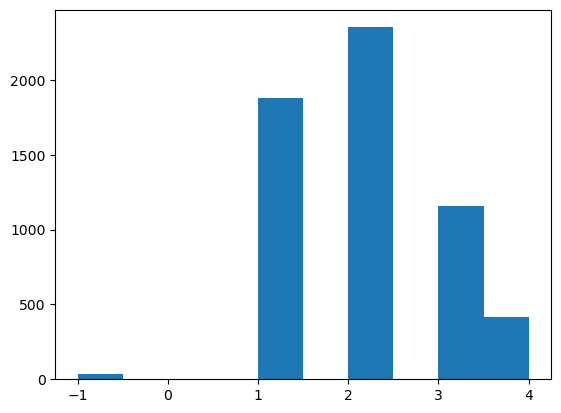

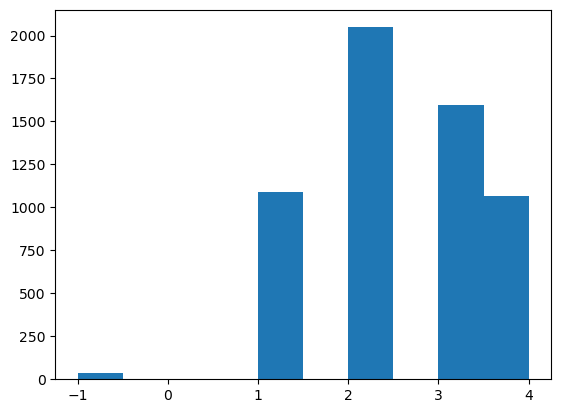

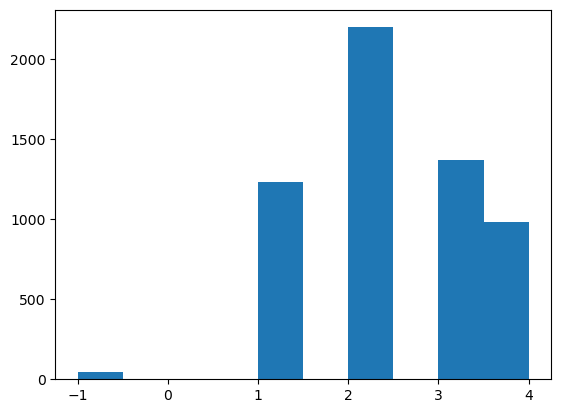

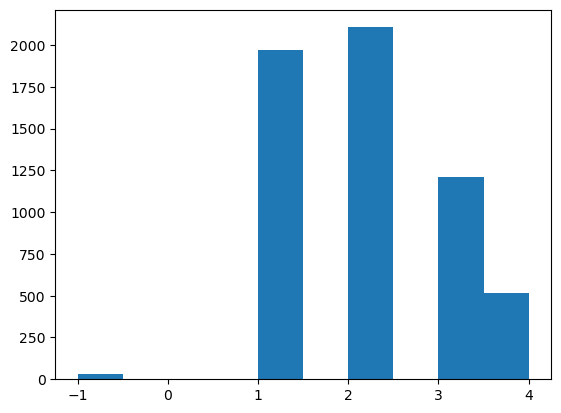

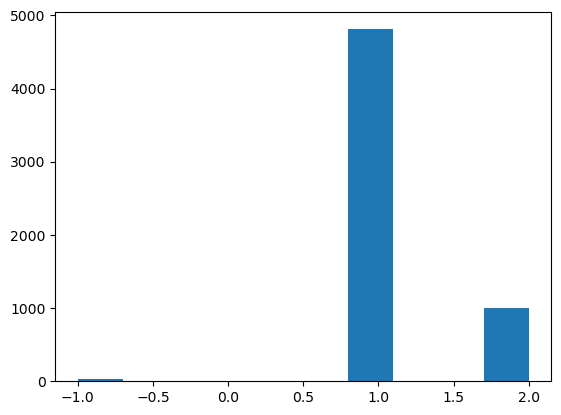

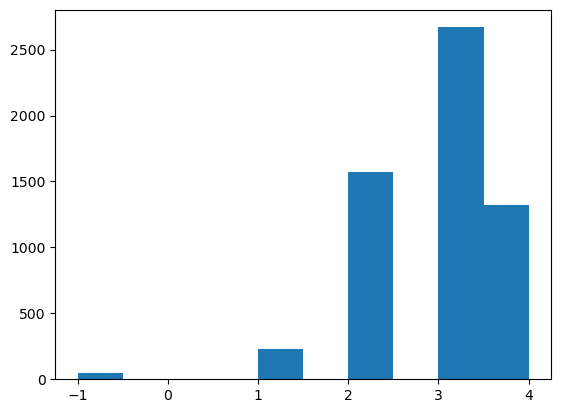

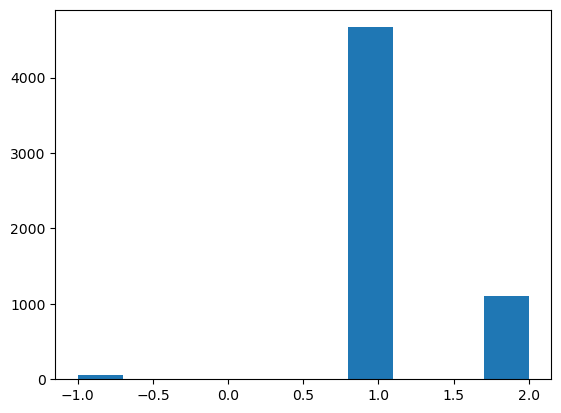

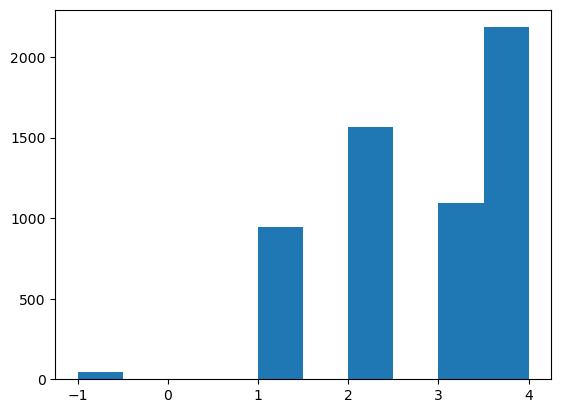

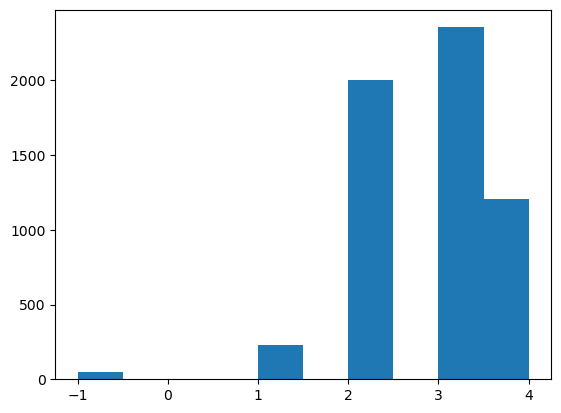

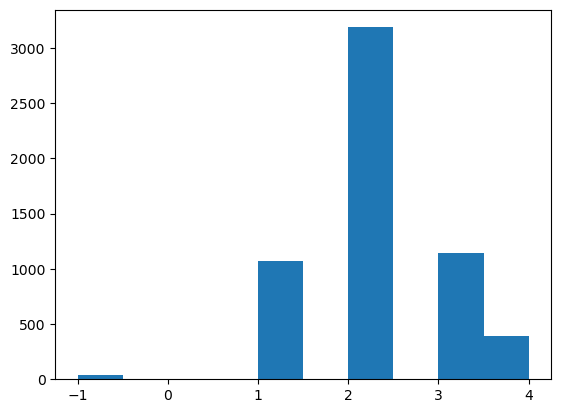

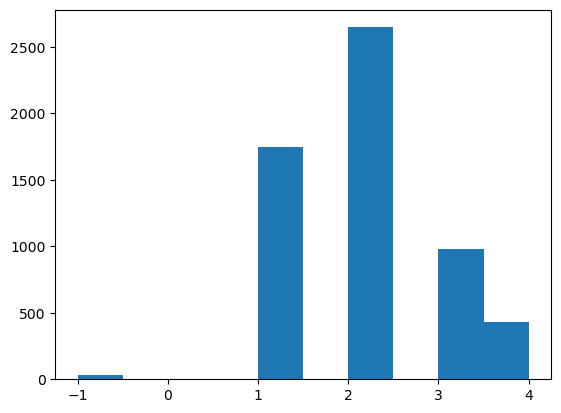

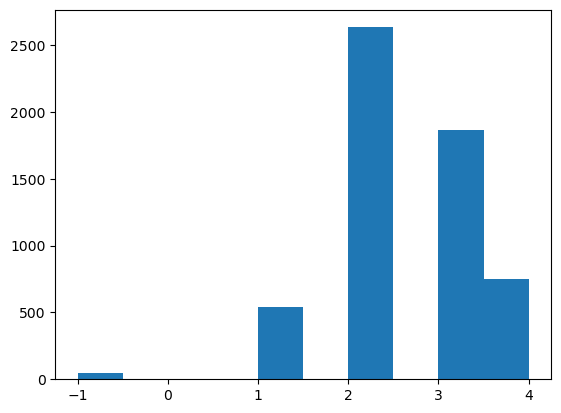

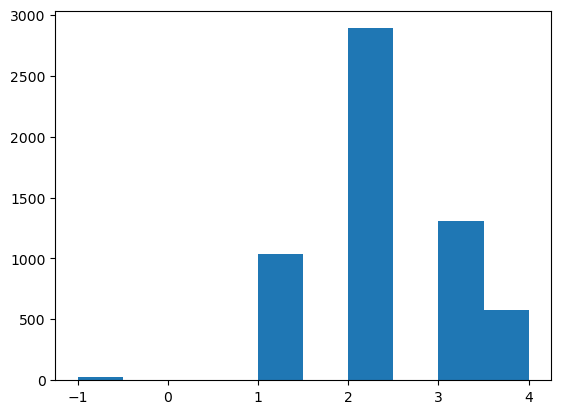

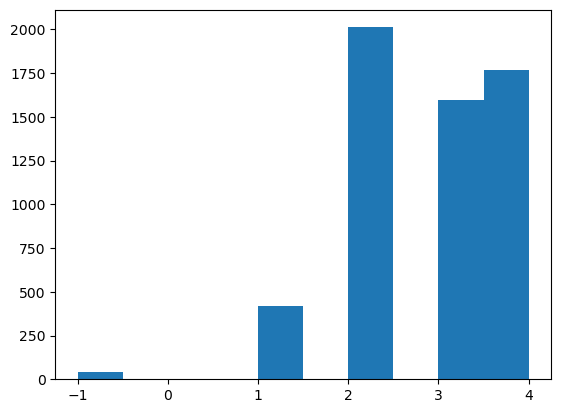

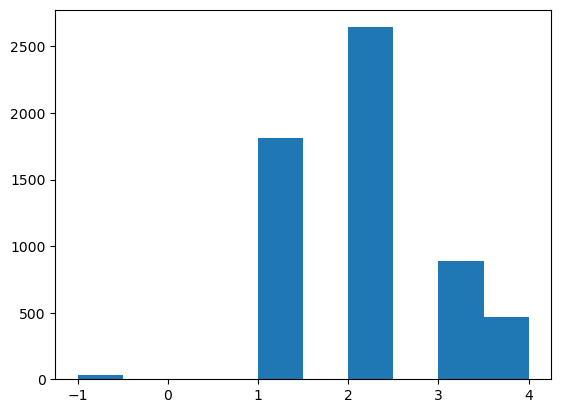

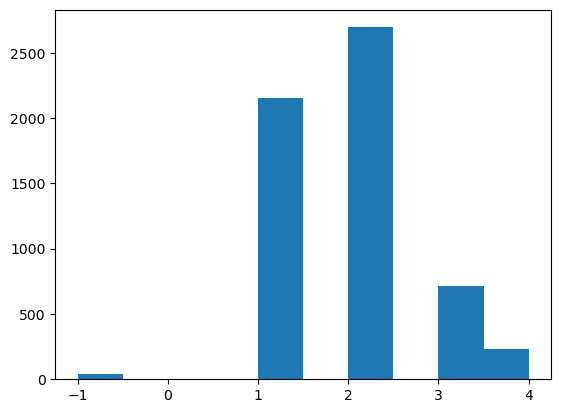

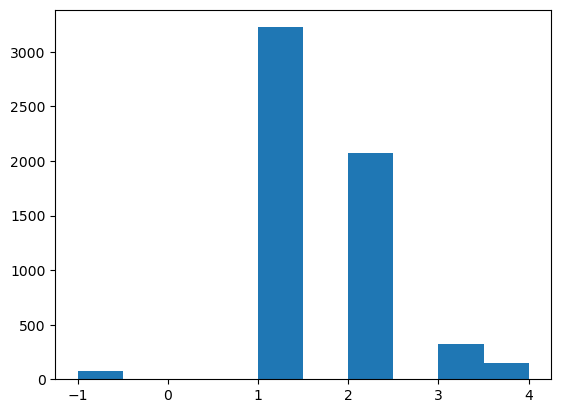

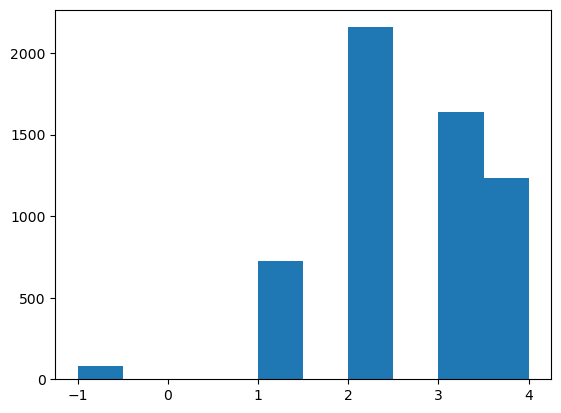

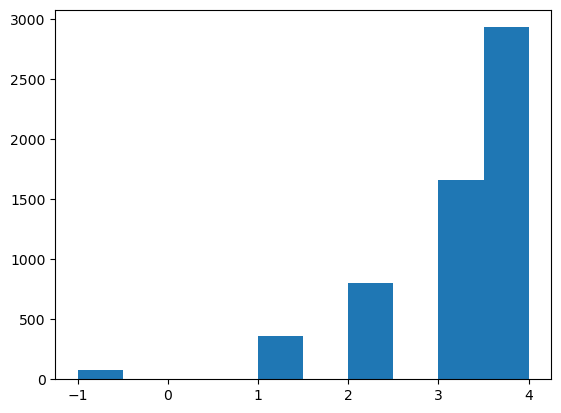

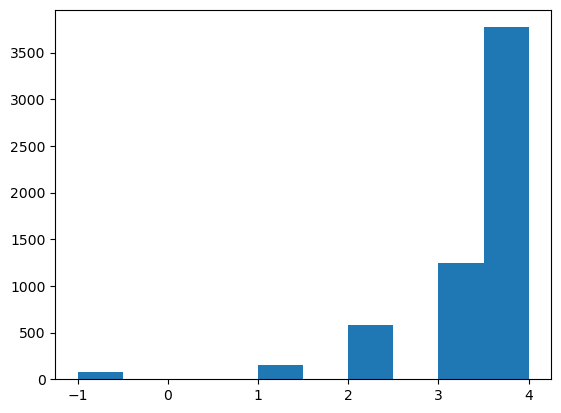

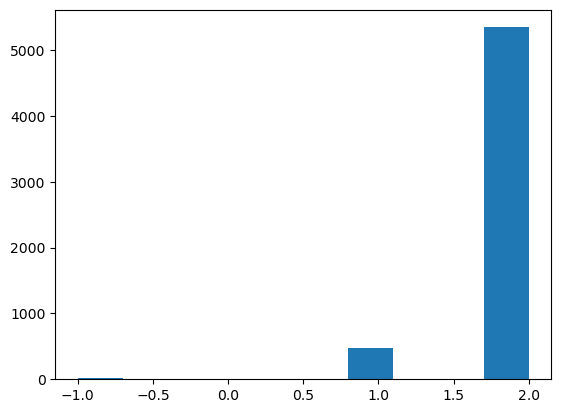

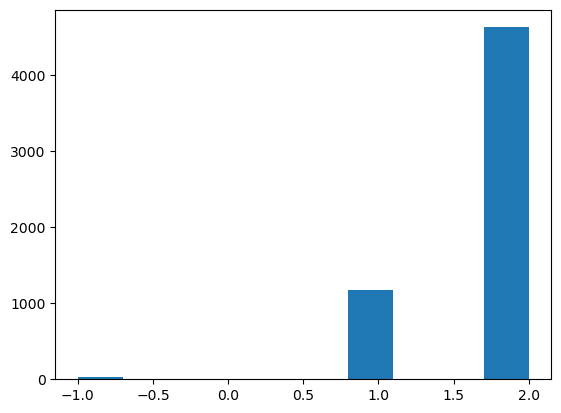

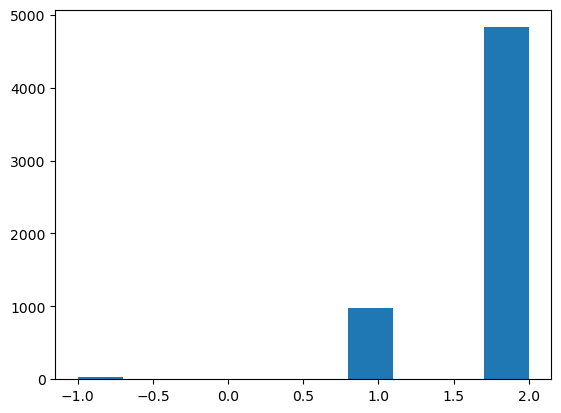

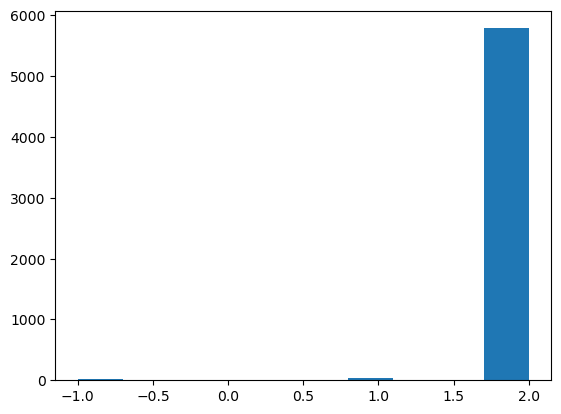

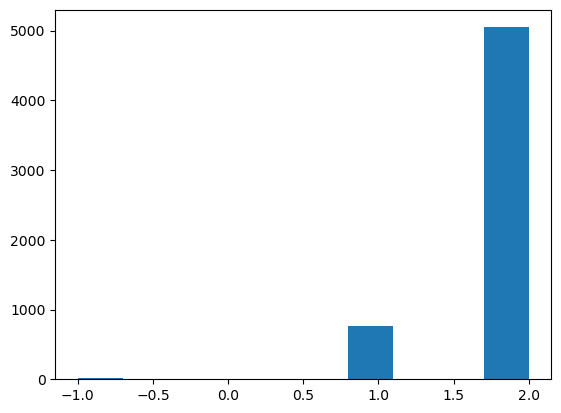

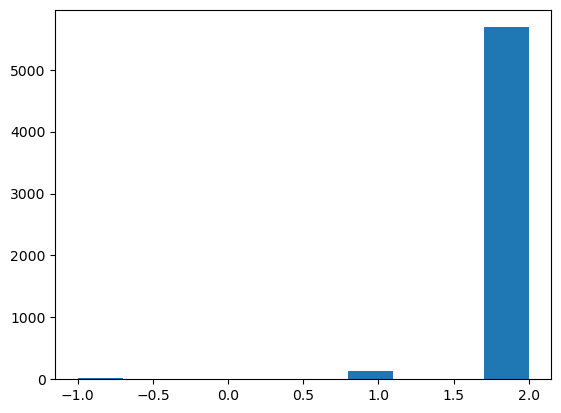

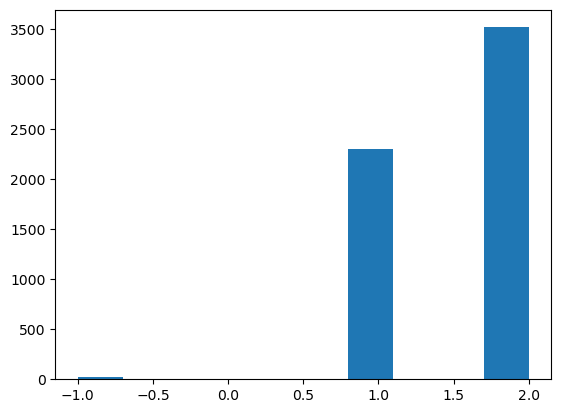

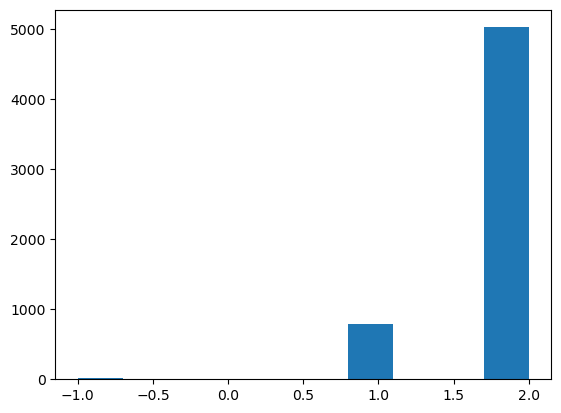

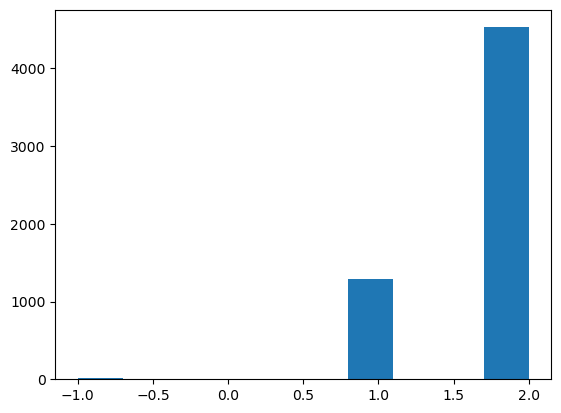

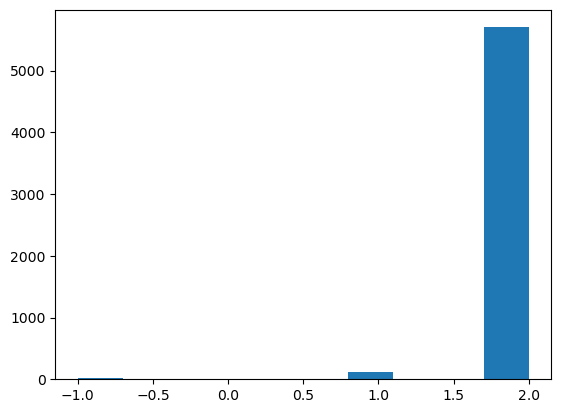

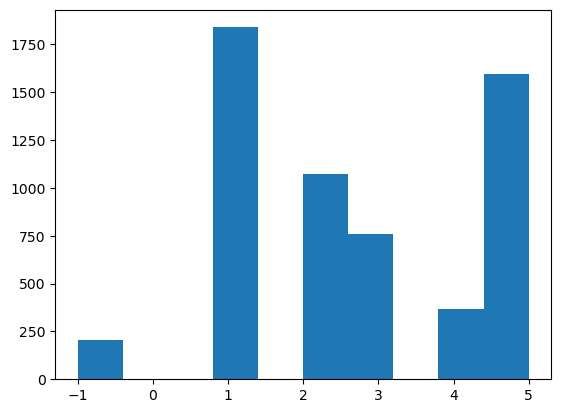

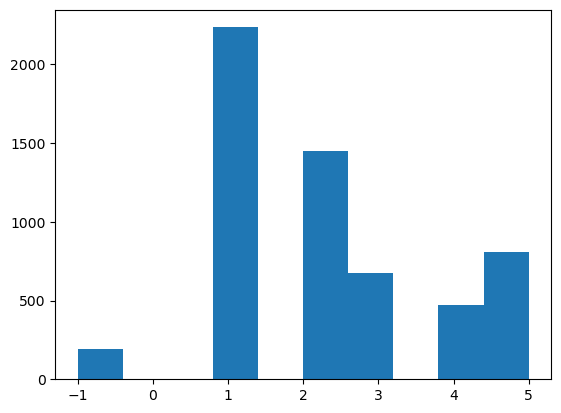

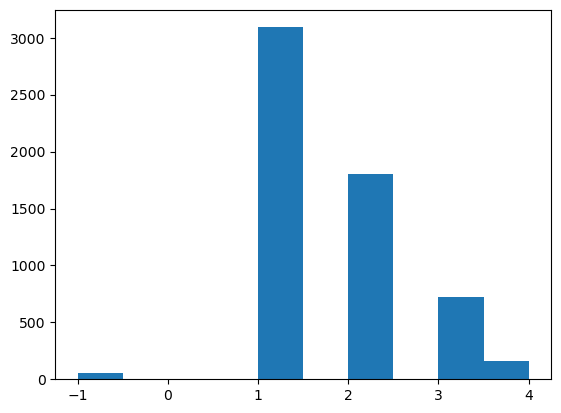

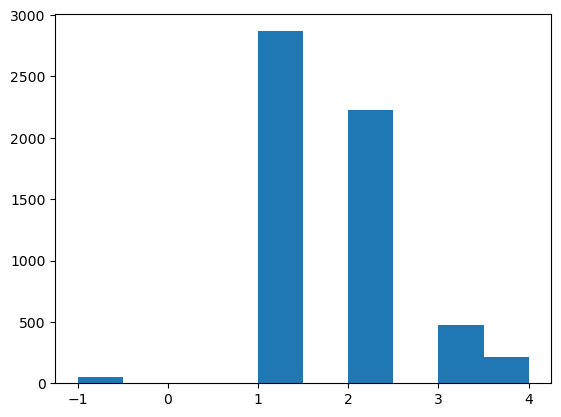

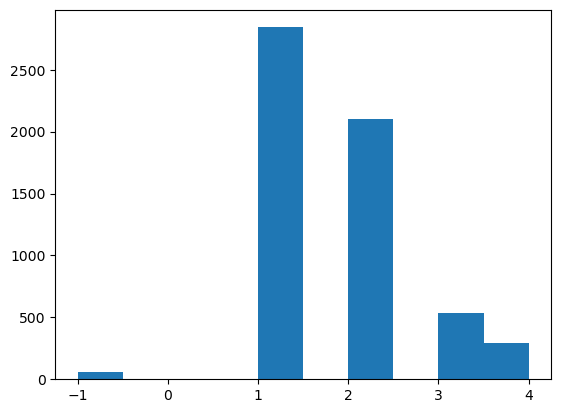

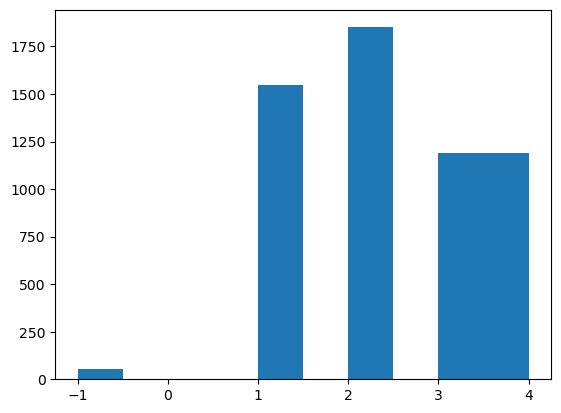

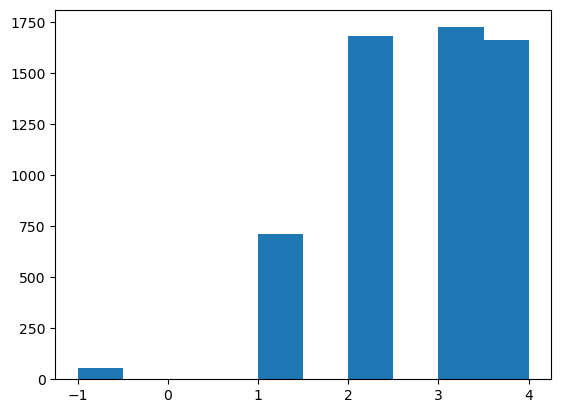

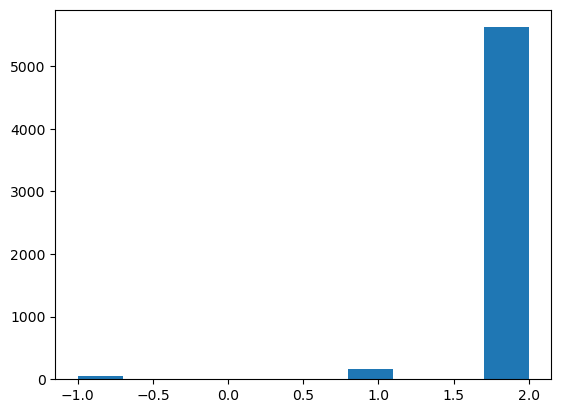

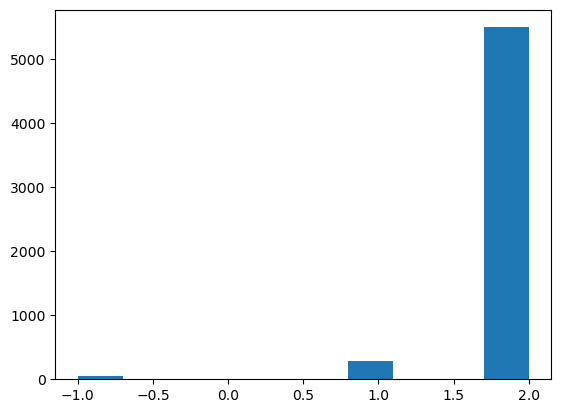

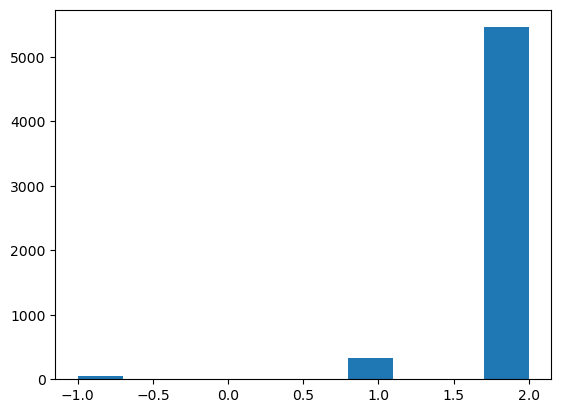

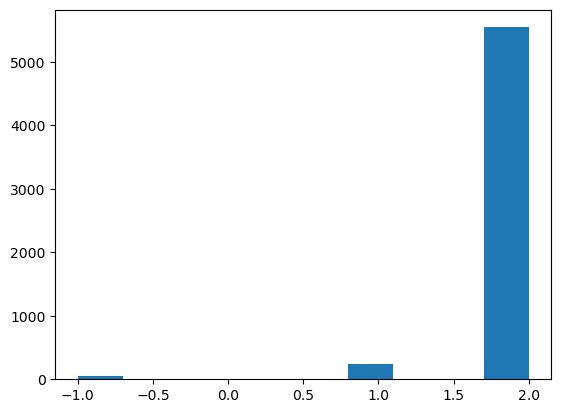

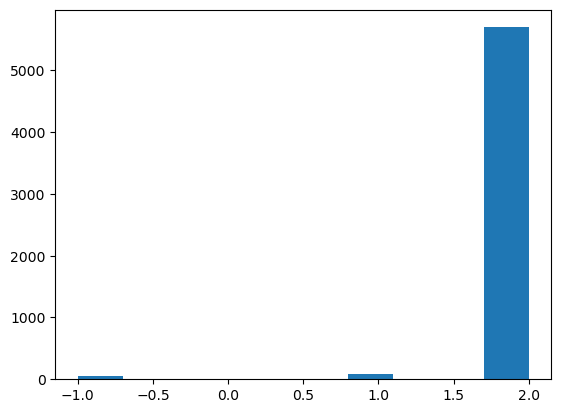

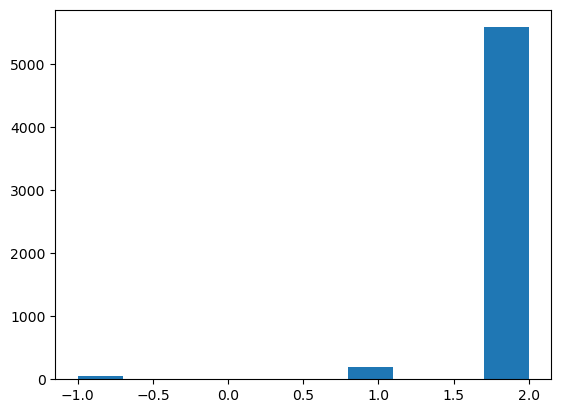

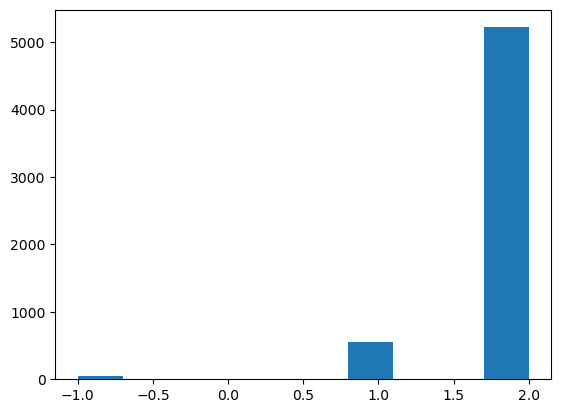

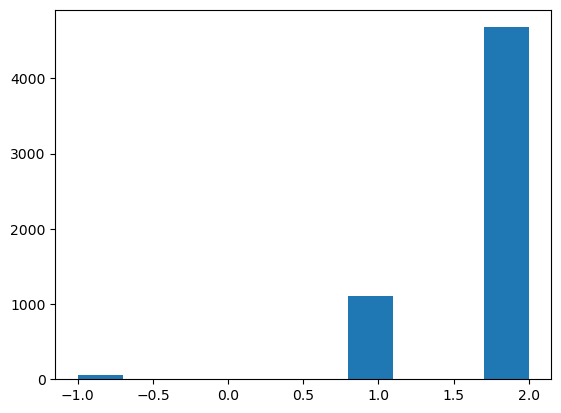

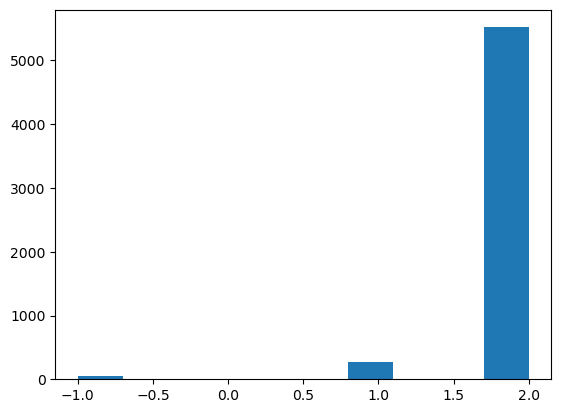

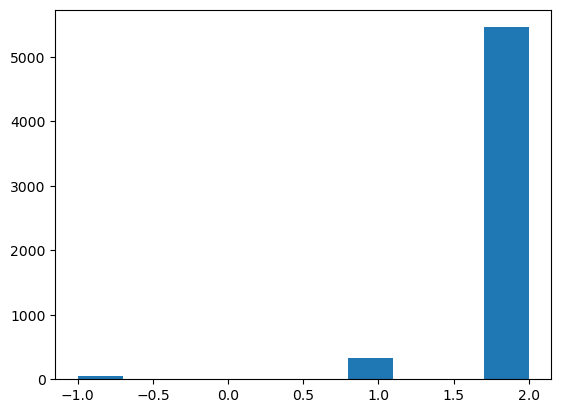

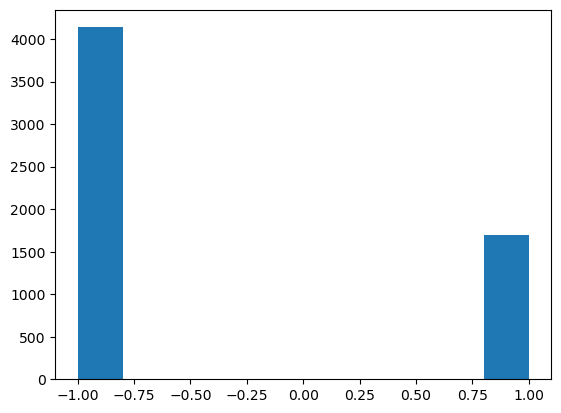

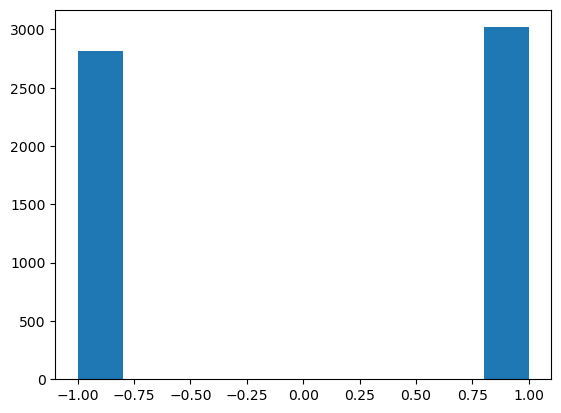

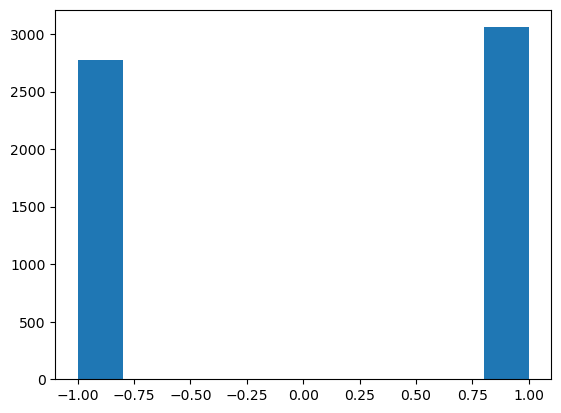

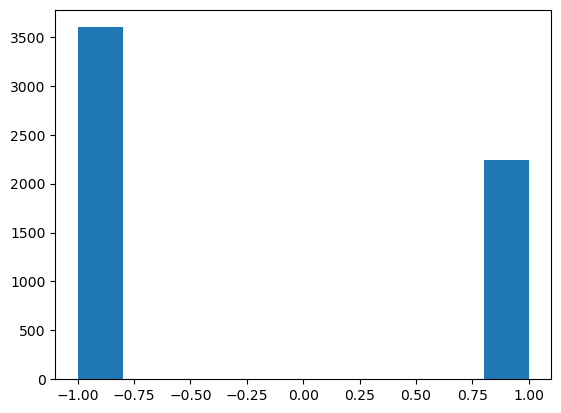

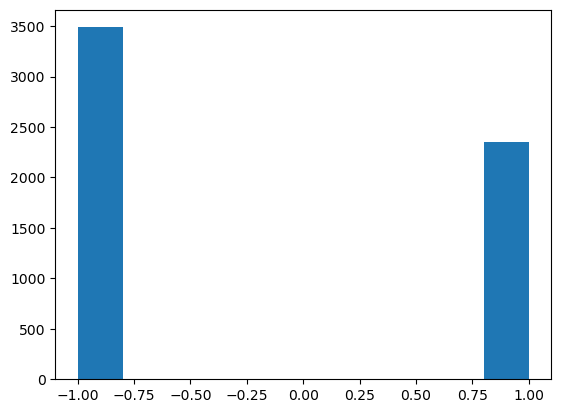

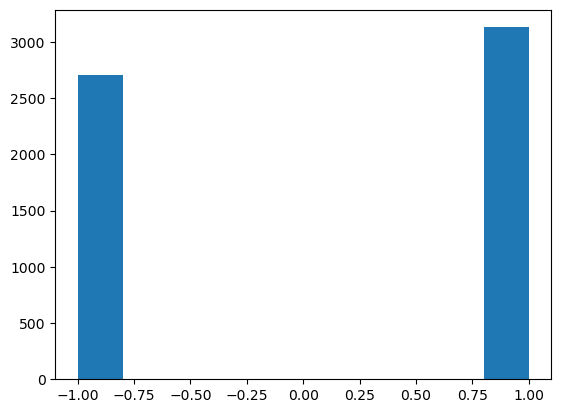

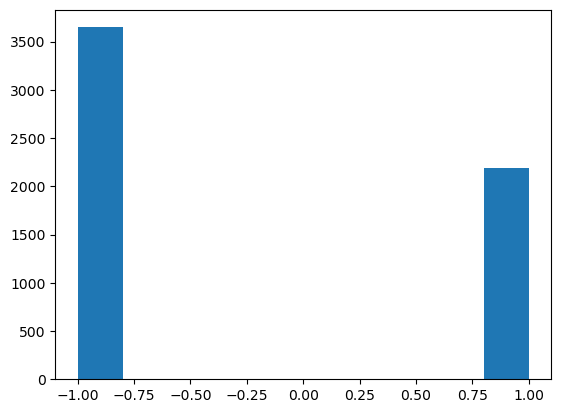

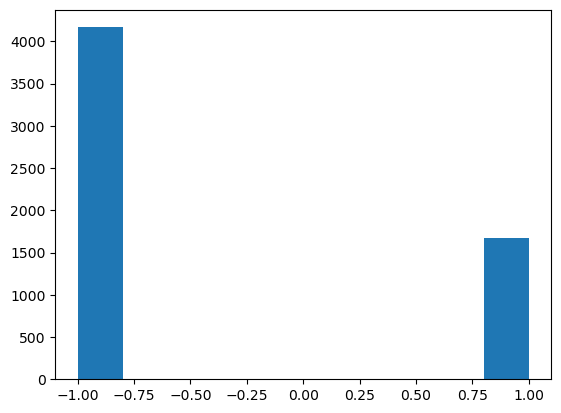

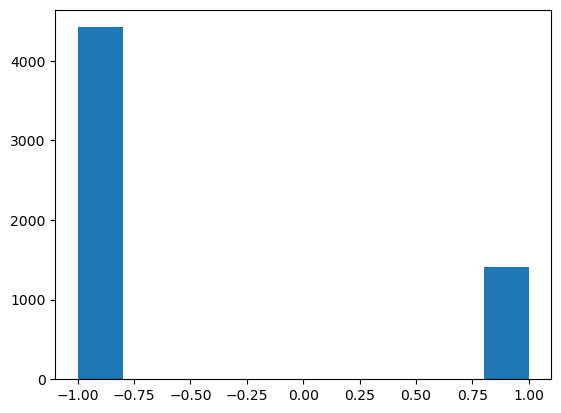

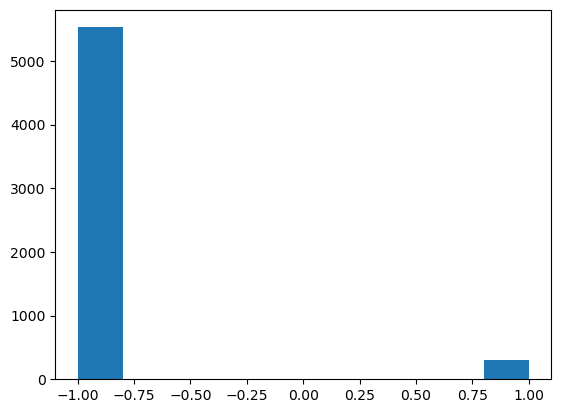

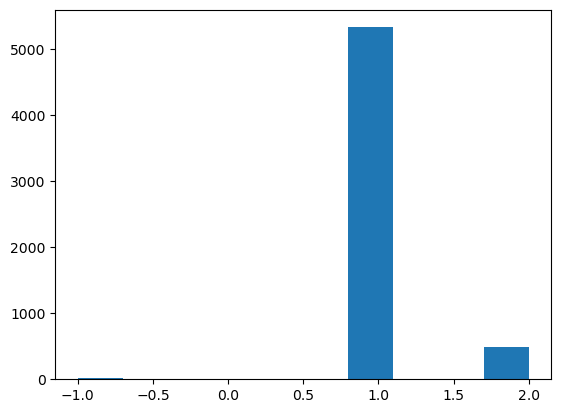

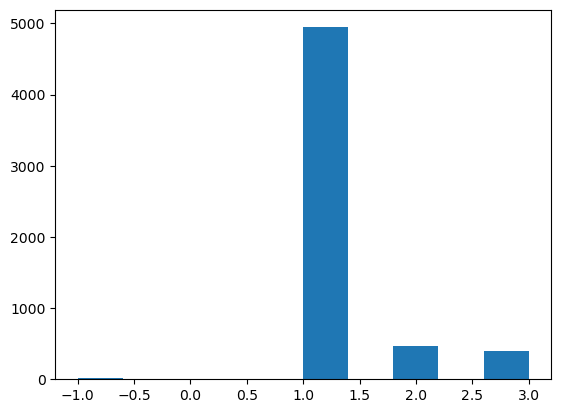

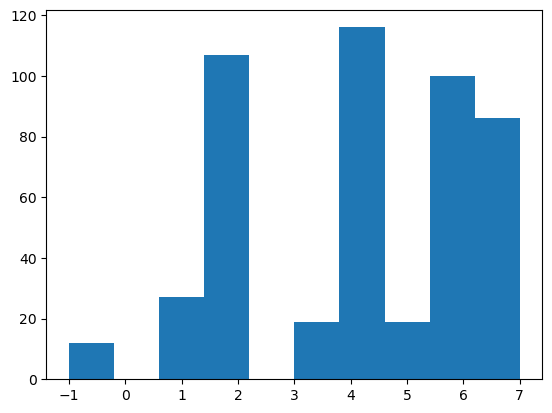

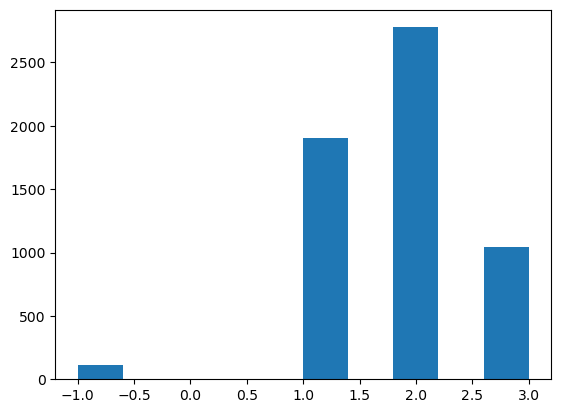

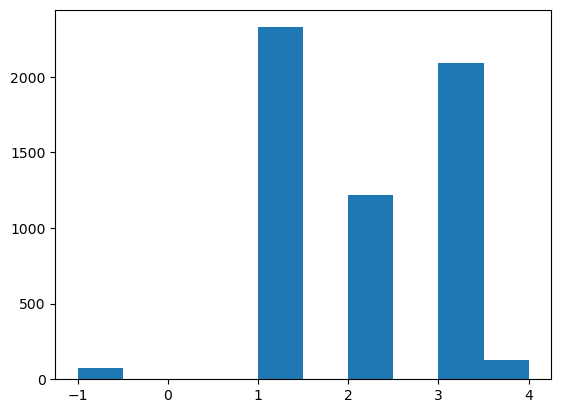

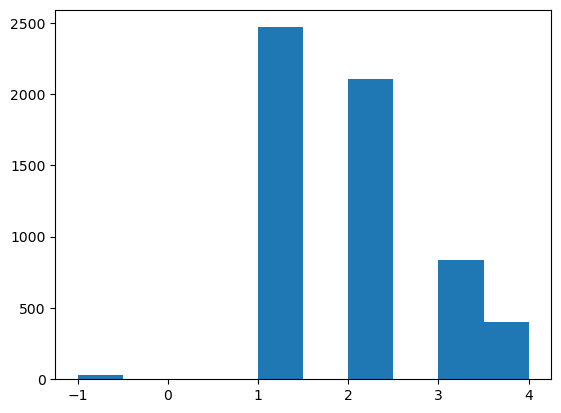

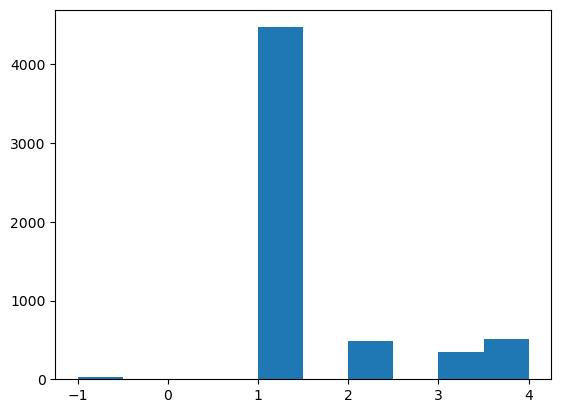

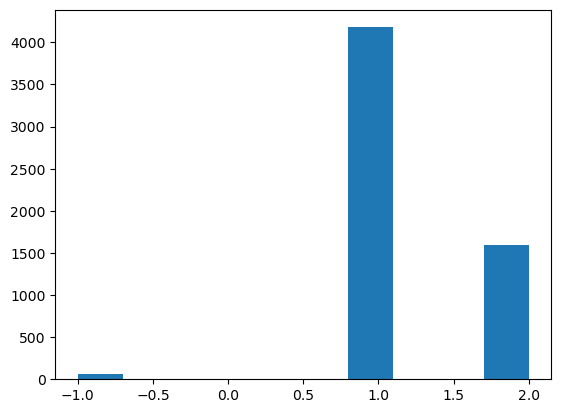

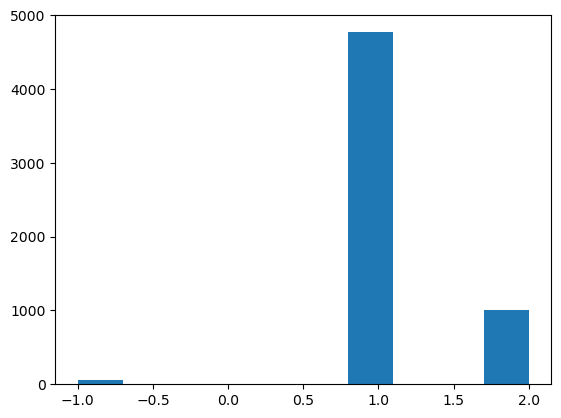

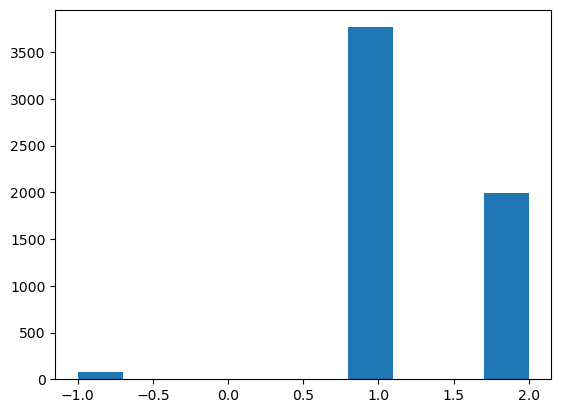

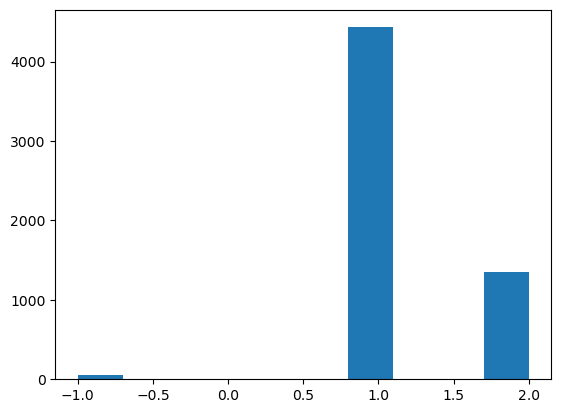

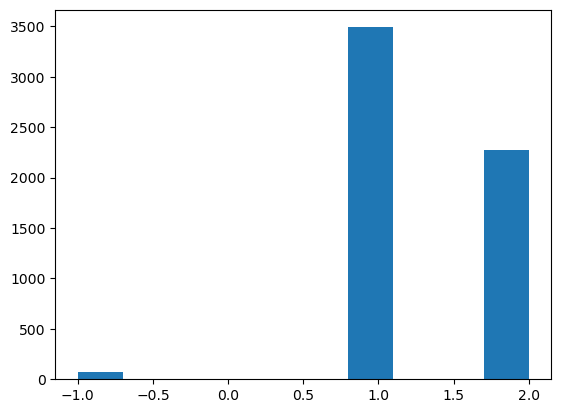

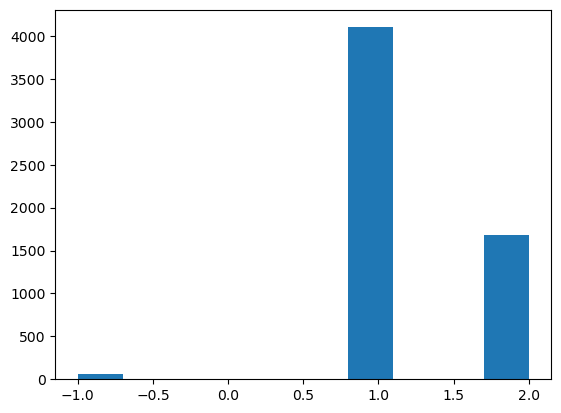

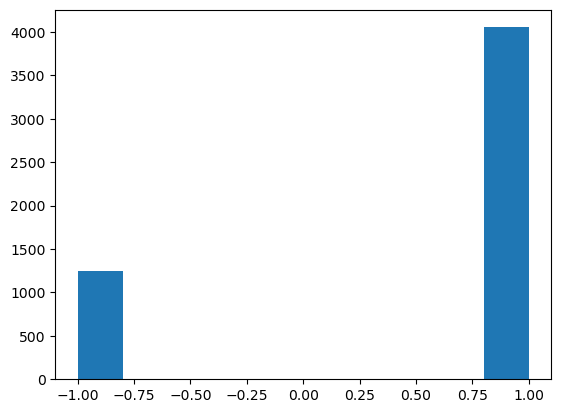

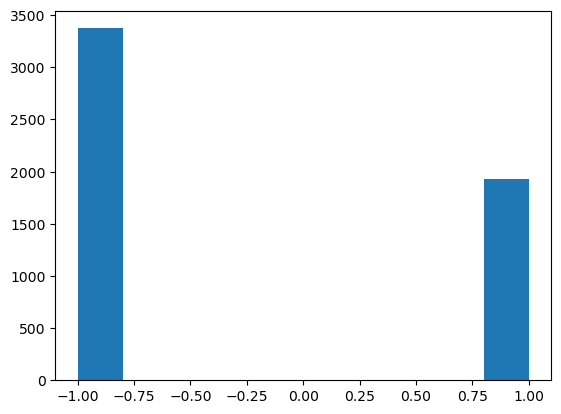

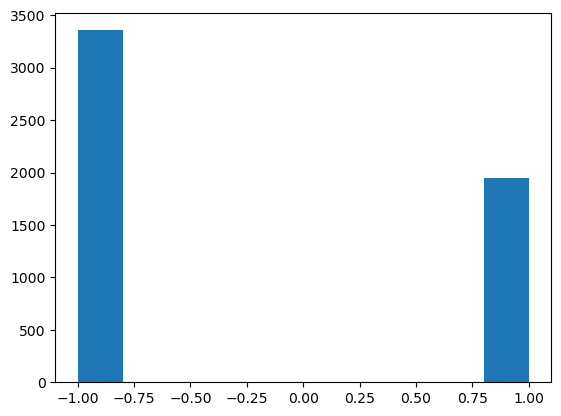

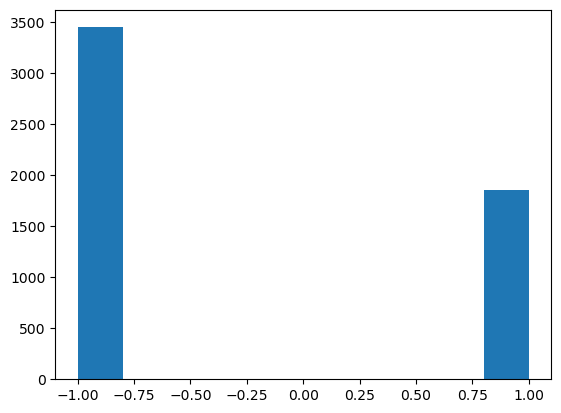

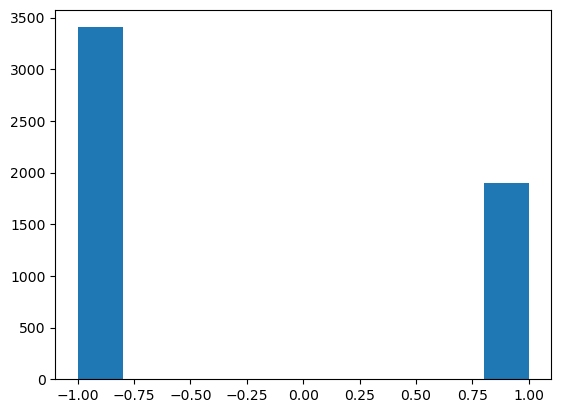

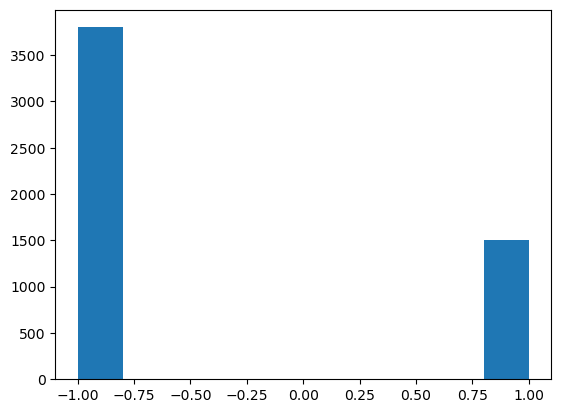

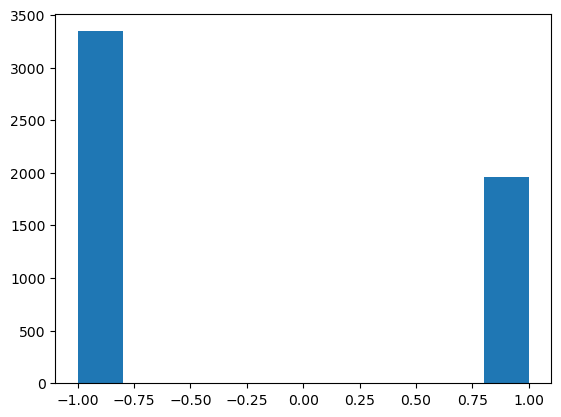

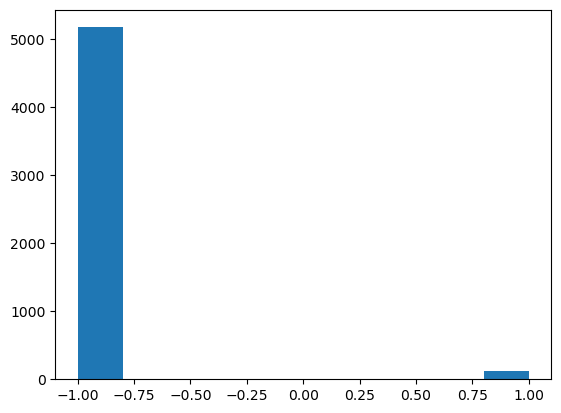

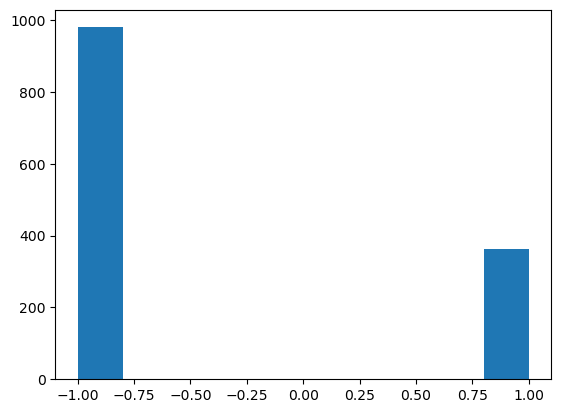

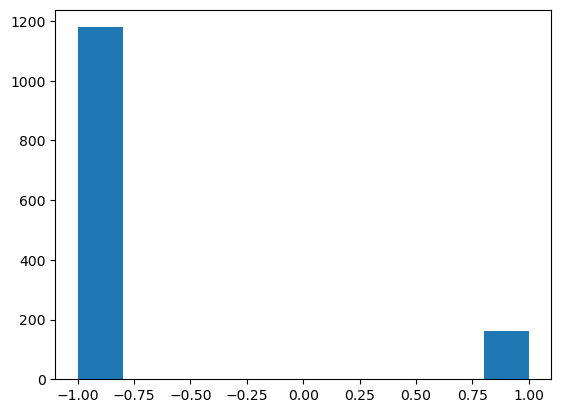

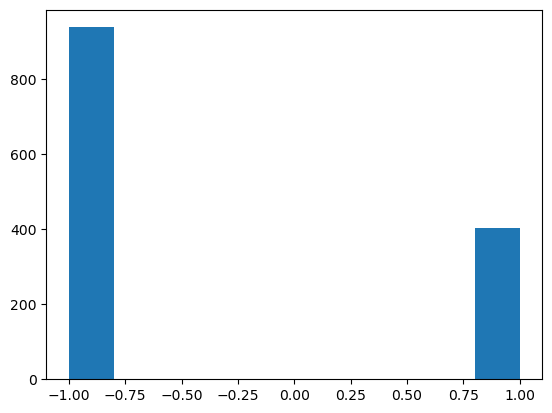

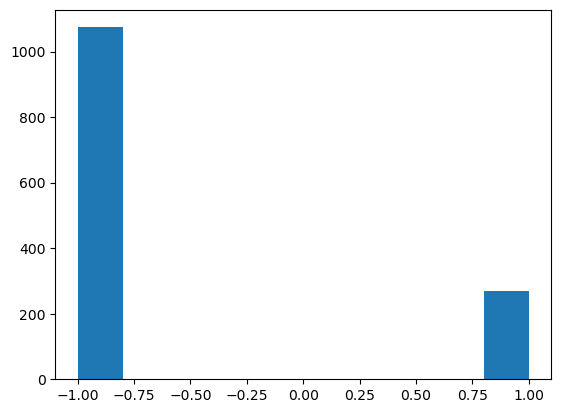

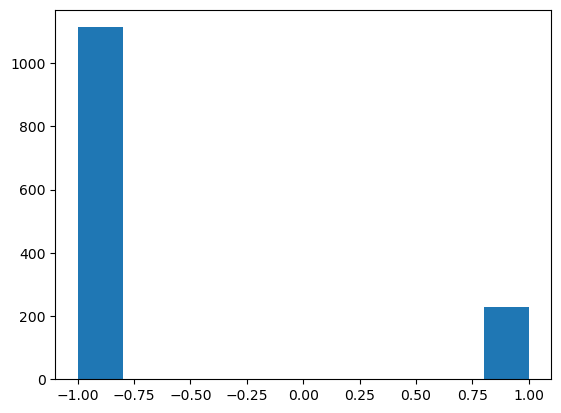

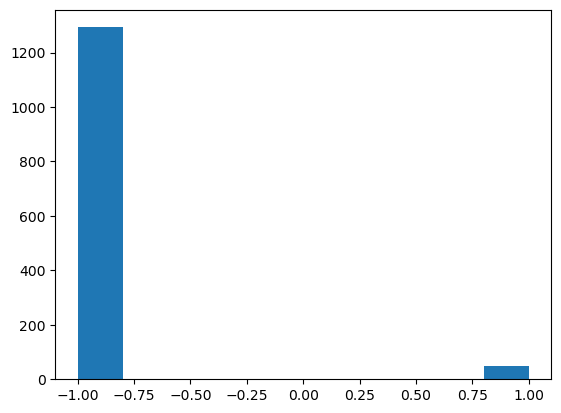

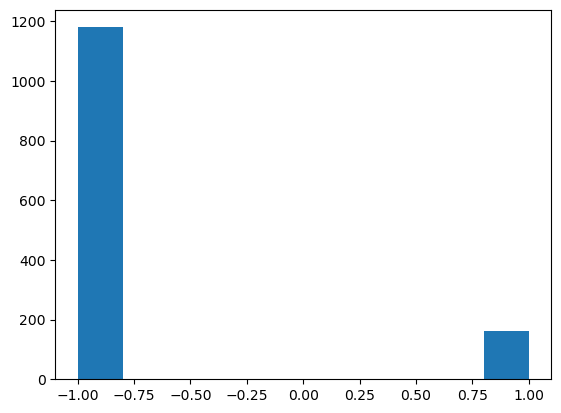

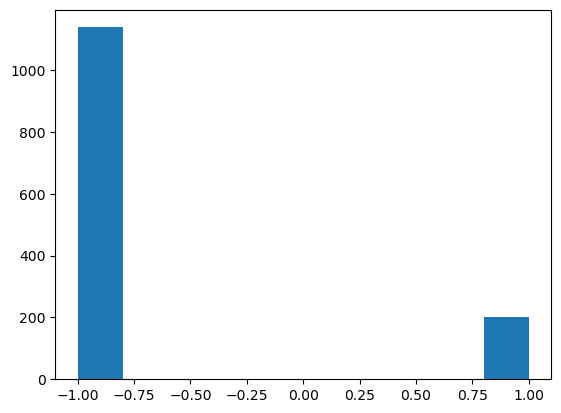

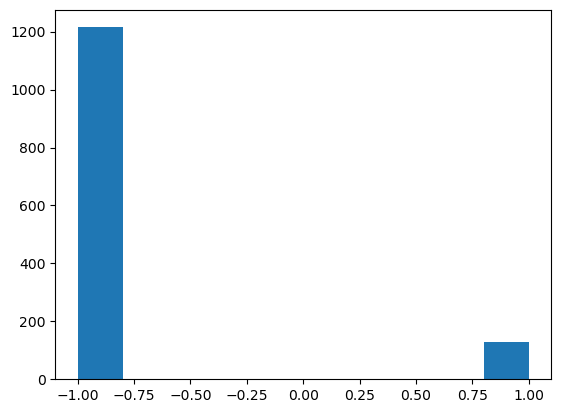

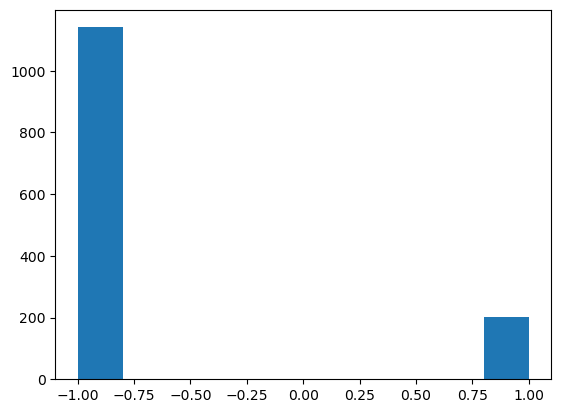

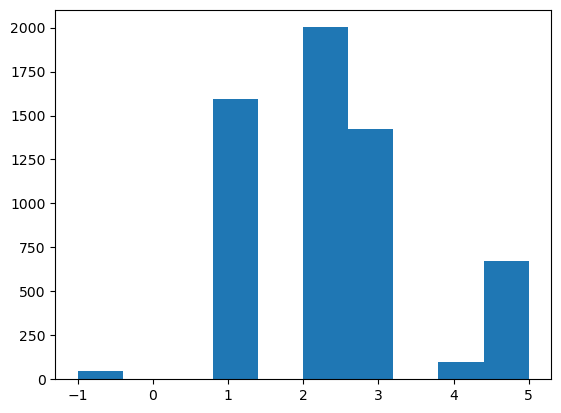

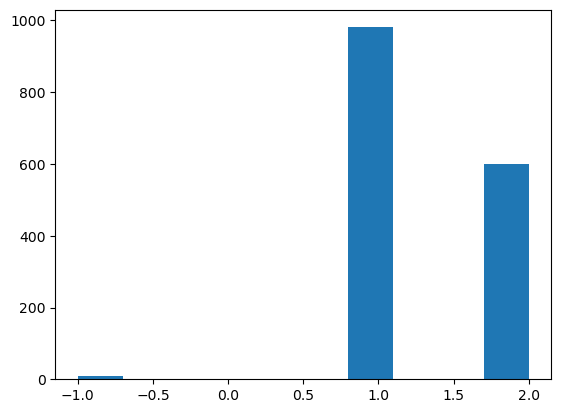

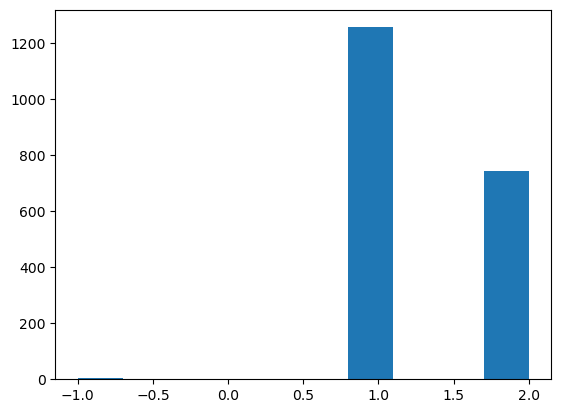

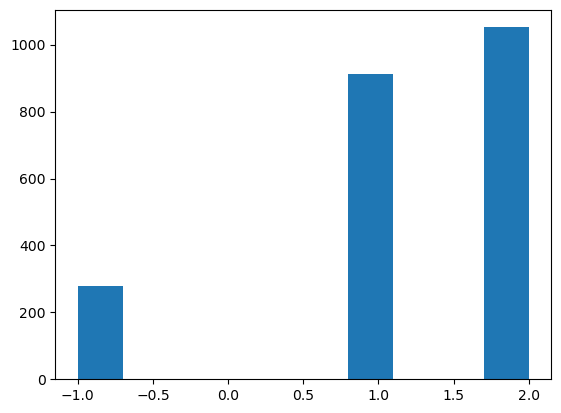

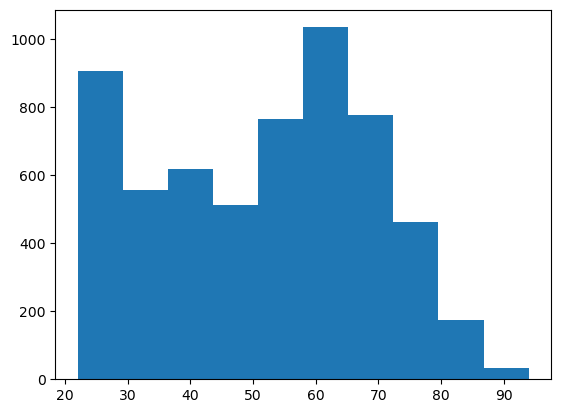

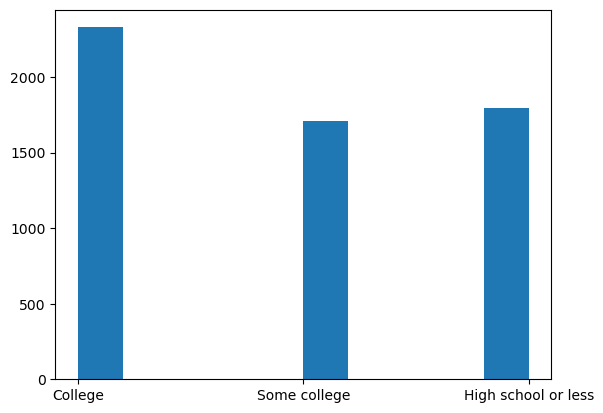

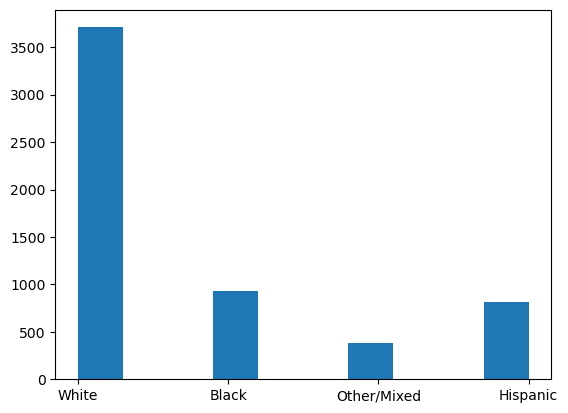

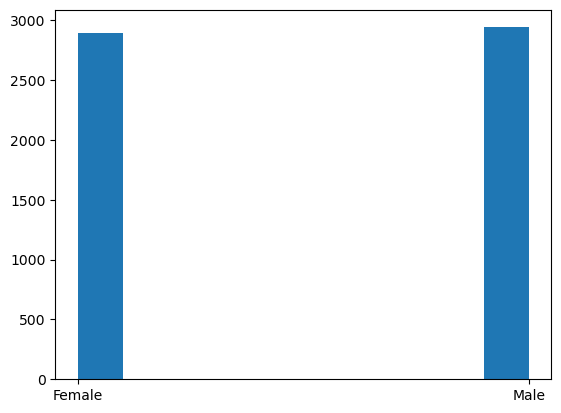

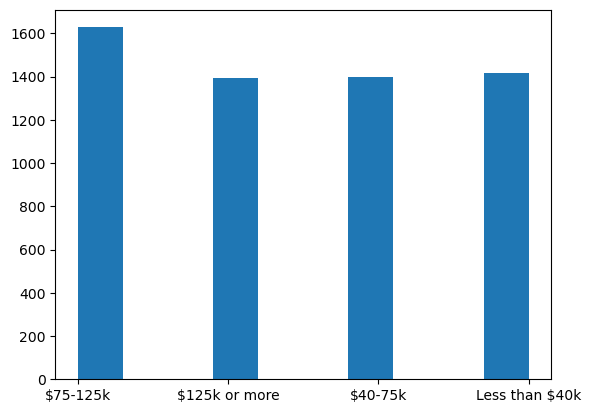

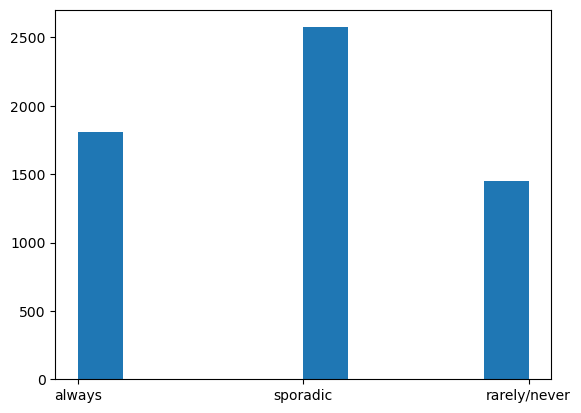

In [12]:
import matplotlib.pyplot as plt
for column in df.columns.to_list():
    plt.figure()
    plt.hist(df[column])

In [8]:
#We convert the voting results into a numeric value for use in RandomForestRegressor
import numpy as np
df['prob_vote'] = np.where(df['voter_category'] == 'always', 1,0)
df['prob_vote'] += np.where(df['voter_category'] == 'sporadic', 0.5,0)

In [11]:
df.head()

,RespId,weight,Q1,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,...,Q31,Q32,Q33,ppage,educ,race,gender,income_cat,voter_category,prob_vote
0,470001,0.7516,1,1,1,2,4,1,4,2,...,NaN,1.0,NaN,73,College,White,Female,$75-125k,always,1.0
1,470002,1.0267,1,1,2,2,3,1,1,2,...,NaN,NaN,1.0,90,College,White,Female,$125k or more,always,1.0
2,470003,1.0844,1,1,1,2,2,1,1,2,...,NaN,2.0,NaN,53,College,White,Male,$125k or more,sporadic,0.5
3,470007,0.6817,1,1,1,1,3,1,1,1,...,NaN,1.0,NaN,58,Some college,Black,Female,$40-75k,sporadic,0.5
4,480008,0.9910,1,1,1,-1,1,1,1,1,...,-1.0,NaN,NaN,81,High school or less,White,Male,$40-75k,always,1.0


In [50]:
#a random forest regressor hates NaNs--certian questions seem to have a lot of them, 
#so we'll just drop them for now
clean_df = df.dropna(axis=1)

In [51]:
from sklearn.ensemble import RandomForestRegressor

#with the remaing data points--we can craft a random forest regressor
clean_columns = clean_df.columns.to_list()
x_feat_list = clean_columns[2:92]

x = df.loc[:, x_feat_list].values
y = df.loc[:, 'prob_vote']

rfr = RandomForestRegressor(n_estimators = 1000)
# Train the model on training data
rfr.fit(x, y)

RandomForestRegressor(n_estimators=1000)

code from class to pull the most important features for a regressor out into a plot

In [52]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None, \
                     label = 'Feature importance\n(Mean decrease in Gini across all Decision Trees)'):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        
        sorted_idx = rfr.feature_importances_.argsort()
        new_feat_list = list()
        new_feat_import = list()
        
        for i in range(limit):
            sindex = sorted_idx[-(i+1)]
            new_feat_list.append(x_feat_list[sindex])
            new_feat_import.append(rfr.feature_importances_.tolist()[sindex])
        
        '''# limit to the first limit feature
        feat_list = feat_list[sorted_idx][:limit]
        feat_import = feat_import[sorted_idx][:limit]'''
    if limit is None:
        new_feat_list = feat_list
        new_feat_import = feat_import
    
    # plot and label feature importance
    plt.barh(new_feat_list, new_feat_import)
    plt.gcf().set_size_inches(5, len(new_feat_list) / 2)
    plt.xlabel(label)

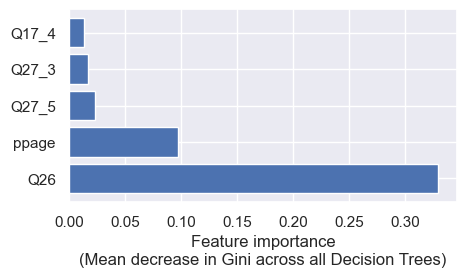

In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plot_feat_import(x_feat_list, rfr.feature_importances_, limit = 5)

We see that Question 26 had a noticbly high importance--in the future we'll examine why this might be.

Remark: the survey includes demographic information--this information is non-numerical however and would do poorly in a RFR--with one-hot encoding they could likely be included. 

ppage (participants age) was included as it is naturally numeric. It impressive that the only included demographic datapoint was so important to the model.

3. We plan to clean our data to utilize a random forest classifier that includes demographic questions--and find feature importance to determine which question response has the highest effect on voting. We also want to use principal component analysis to group people into general categories. We want to see if these categories align with the perceptions of voting groups. We may also preform clustering analyasis.

The proposal mentions only examine a few, obviously relevant questions—we would like to train a model on these preselected questions and a model using all available data, to see if seemingly irellevent responses correlate with voting frequency or if these are truly white noise